# Starbucks Capstone Challenge

## Project Overview

### Introduction

#### Project Origin
Starbucks is an enthusiastic retailer of coffee and other beverages with its corporate headquarters in Seattle, Washington. The company is listed as the 121st Fortune 500 company for 2019. Registered users of their mobile application can order coffee for pickup while on the go, pay in-store using the app, and get rewards points that provides these users with promos for extra points. The promotional offer could simply be a drink marketing or it could be a real deal, like a discount or a BOGO (buy one, get one free) deal. 

#### Problem domain
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example
To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning
This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Data Sets
The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)

profile.json - demographic data for each customer

transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

*portfolio.json*

id (string) - offer id
offer_type (string) - type of offer ie BOGO, discount, informational
difficulty (int) - minimum required spend to complete an offer
reward (int) - reward given for completing an offer
duration (int) - time for offer to be open, in days
channels (list of strings)

*profile.json*

age (int) - age of the customer
became_member_on (int) - date when customer created an app account
gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
id (str) - customer id
income (float) - customer's income

*transcript.json*

event (str) - record description (ie transaction, offer received, offer viewed, etc.)
person (str) - customer id
time (int) - time in hours since start of test. The data begins at time t=0
value - (dict of strings) - either an offer id or transaction amount depending on the record

## Problem Statement
The objective is to evaluate which kind of offer to deliver to each user based on their response to the offers that have already been made to them. Utilizing the data set provided by Starbucks, which was collected over 30 days, to address the fact that not all users receive the same offer. Also, the main goal is to create a machine-learning model that predicts how a customer will react to an offer.

## Metrics
To evaluate the effectiveness of the strategy and identify which model produces the best outcomes, I will use the F1 score as the model metric. It can be understood as the weighted average of recall and precision. The traditional or balanced F-score (F1 score), which has a greatest value of 1 and a worst value of 0, is the harmonic mean of precision and recall.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# read in the json files
portfolio = pd.read_json('./dataset/portfolio.json', orient='records', lines=True)
profile = pd.read_json('./dataset/profile.json', orient='records', lines=True)
transcript = pd.read_json('./dataset/transcript.json', orient='records', lines=True)

# 1. Dataset Exploration

## 1.1 Exploring and pre-processing portfolio data

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
print(f"portfolio -> Rows: {str(portfolio.shape[0])}, Columns: {str(portfolio.shape[1])}")

portfolio -> Rows: 10, Columns: 6


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
def horizontal_bar_plot(df, colmname, pltitle, pltfigsz=[5,5], invertAxis=True, fntsize=12, fontwght='bold'):
    """
    Creates a horizontal bar plot with counts of categories
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colmname: The name of the column containing the categories.
    
    pltitle: The plot title.
    
    pltfigsz: The figure size of the plot (default is [5,5]).
    
    invertAxis: A flag to indicating whether to invert the Y-Axis or not.
    
    fntsize: The font size of text (default to 12 point font size)
    
    fontwght: The weight of font (default to 'bold', it could be 'italic')
    
    Returns
    -------
    None
    """
    plt.figure(figsize=pltfigsz)
    fig, ax = plt.subplots()    
    y_counts = df[colmname].value_counts()
    if invertAxis == True:
        y_counts.plot(kind='barh').invert_yaxis()
    else:
         y_counts.plot(kind='barh')   
    for i, v in enumerate(y_counts):
        ax.text(v, i, str(v), color='black', fontsize=fntsize, fontweight=fontwght)
        plt.title(pltitle)

<Figure size 360x360 with 0 Axes>

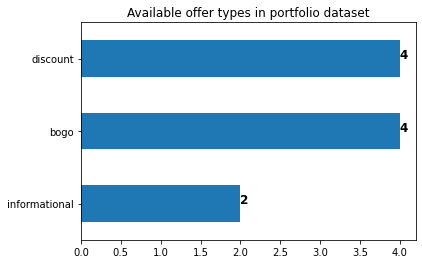

In [7]:
horizontal_bar_plot(portfolio, 'offer_type', "Available offer types in portfolio dataset")

<Figure size 360x360 with 0 Axes>

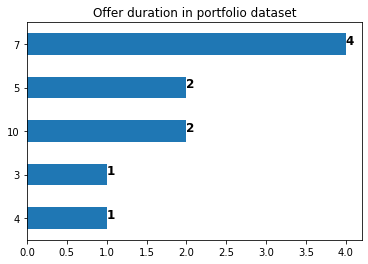

In [8]:
horizontal_bar_plot(portfolio, 'duration', "Offer duration in portfolio dataset")

## 1.2 Exploring and pre-processing profile data

In [9]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
print(f"profile -> Rows: {str(profile.shape[0])}, Columns: {str(profile.shape[1])}")

profile -> Rows: 17000, Columns: 5


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [12]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [13]:
#check for null values 
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [14]:
profile[profile['age']== 118].age.count()

2175

According to the description of the profile data frame and checking null values, it looks like values of gender & income are missing where age is 118. Let's print the values with age 118.

In [15]:
profile[profile['age']== 118].drop(['became_member_on' ,'id'], axis=1)

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
...,...,...,...
16980,None,118,NaN
16982,None,118,NaN
16989,None,118,NaN
16991,None,118,NaN


Thus, it is confirmed that both gender & income for the age 118 are missing. All missing age values are encoded as 118.

## 1.2.1 Analysing the age values in the profile dataframe

In [16]:
#check for different age values
profile.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [17]:
#check for age above 80 and less than 118 
profile[(profile['age'] > 80) & (profile['age'] < 118)]

,gender,age,id,became_member_on,income
33,F,96,868317b9be554cb18e50bc68484749a2,20171117,89000.0
94,F,89,4264b1d027cc493281bba4f44bfedaca,20171114,87000.0
98,F,90,1c587de019994f93a242c6864fd7bc55,20151210,98000.0
126,M,83,4c29d22467af4d7faa137c4eedd65340,20180127,46000.0
131,F,89,3dae0eadb47149b0b9b548d14548524b,20180114,65000.0
...,...,...,...,...,...
16914,M,87,d1c4500ace2e45e9a45d3cd2fccac8d8,20140920,59000.0
16933,M,85,a65353ea28ff442aabfb39eb974326e3,20161001,96000.0
16938,F,89,da7bf9d84fd74a72bdee595007bcca7a,20170413,68000.0
16981,M,84,1966fa40d2f84620b2b1b9b64f8e0209,20160629,93000.0


Let us create a boxplot to find the outliers in our data frame

<AxesSubplot:xlabel='age'>

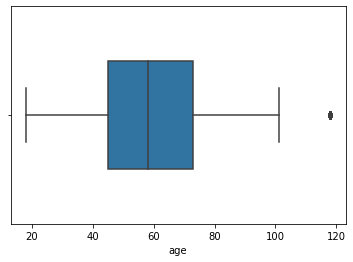

In [18]:
sns.boxplot(profile['age'], width=0.5)

It seems to be like people with age greater than 80 don't use the app much or they may not drink much beverages. So, I'll consider people with the above age as outliers.

## 1.2.2 Gender counts in the profile dataframe

<Figure size 360x360 with 0 Axes>

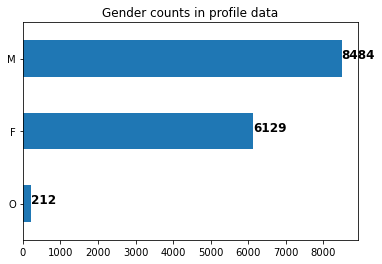

In [19]:
horizontal_bar_plot(profile, 'gender', "Gender counts in profile data")

In [20]:
def exploded_pie_plot(df, colName, pltTitle, pltColors=[], pltLabels=[], pltExplode=(), pltFigSize=[5, 5]):
    """
    Creates an exploded pie plot with percentages of each categories for the column provided.
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colName: The name of the column containing the categories.
    
    pltTitle: The plot title.
    
    pltColors: The array of colors to use.
    
    pltLabels: The array of plot labels to use for each of the categories.
    
    pltExplode: The proportions to pass in for exploding the slices (e.g. 0.1, 0, 0 will explode the first category out by 10%)
    
    pltFigSize: The figure size of the plot (default is [5,5])
    
    Returns
    -------
    None
    """
    plt.figure(figsize=[5, 5])
    pltValues = df[colName].value_counts()
    colors = pltColors
    labels = pltLabels
    explode = pltExplode # if (0.1, 0, 0) then explode 1st slice by 10% and dont explode 2nd and 3rd slizes
    plt.pie(pltValues, colors=pltColors, labels=pltLabels, explode=pltExplode, autopct='%1.2f%%', counterclock=False, shadow=True)
    plt.title(pltTitle)

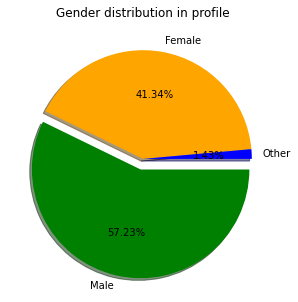

In [21]:
exploded_pie_plot(profile, 'gender', 'Gender distribution in profile', ['green', 'orange', 'blue'], ['Male', 'Female', 'Other'], (0.1, 0, 0))

## 1.3 Exploring and pre-processing transcript data

In [22]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [23]:
print(f"transcript -> Rows: {str(transcript.shape[0])}, Columns: {str(transcript.shape[1])}")

transcript -> Rows: 306534, Columns: 4


In [24]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [25]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [26]:
#check for null values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

<Figure size 360x360 with 0 Axes>

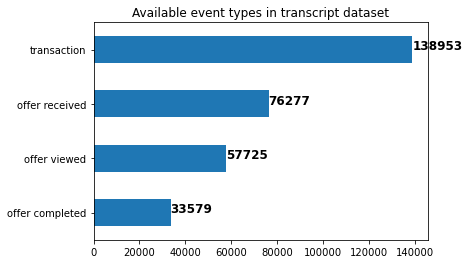

In [27]:
horizontal_bar_plot(transcript, 'event', "Available event types in transcript dataset")

# 2. Dataset Cleaning and Pre-processing

## 2.1 Cleaning Portfolio data

Renaming some columns for better readability & easiness in merging dataframes later.

In [28]:
def rename_cols(df, new_cols_name):
    """
    Parameters
    ----------
    df: input dataframe for renaming columns
    new_colmn: define new column name for each column
       
    """

    df= df.rename(columns = new_colmn)
    return df

In [29]:
#rename columns
new_colmn = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
cleaned_portfolio = rename_cols(portfolio, new_colmn)

In [30]:
cleaned_portfolio.head()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [31]:
cleaned_portfolio.columns

Index(['offer_reward', 'channels', 'offer_difficulty', 'offer_duration',
       'offer_type', 'offer_id'],
      dtype='object')

## 2.2 Cleaning Profile data

### Tasks:

1. Renaming some columns for better readability & easiness in merging dataframes later.
2. In order to not lose data with null values, it is better to impute them. So, I will consider imputing missing age & income values with mean and missing gender values with mode.
3. Considering people with age above 80 as outliers, remove them from the dataset.
4. Classifying ages into groups for better understanding in Exploratory Data Analysis later:

    • Under 20
    
    • 20 - 45
    
    • 46 - 60
    
    • 61 - 80

In [32]:
#rename columns
new_colmn = {'id':'customer_id' , 'income':'customer_income'}
cleaned_profile = rename_cols(profile, new_colmn)

In [33]:
cleaned_profile.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'customer_income'], dtype='object')

In [34]:
def cleaning_profile(df):
    """
    Clean the profile data frame as per tasks 2-4
        
    Parameters
    ----------   
    df: data frame
    
    """
    
    #deal with null values
    #replace 118 age values with NaN so to replace them easily with mean age
    df.replace(118, np.nan , inplace=True)
    
    #replace NaN age values with mean age
    df['age'] = df['age'].fillna(df['age'].mean())
    
    #replace missing income values with mean income
    df['customer_income'] = df['customer_income'].fillna(df['customer_income'].mean())
    
    #replace missing gender values with mode i.e. most frequent gender
    mode = df['gender'].mode()[0]
    df['gender'] = df['gender'].fillna(mode)
    
    #remove outliers
    df = df[df['age'] <= 80]
    df['age'] = df['age'].astype(int)
    
    #add Age_group column
    df.loc[(df.age < 20) , 'Age_group'] = 'Under 20'
    df.loc[(df.age >= 20) & (df.age <= 45) , 'Age_group'] = '20-45'
    df.loc[(df.age >= 46) & (df.age <= 60) , 'Age_group'] = '46-60'
    df.loc[(df.age >= 61) , 'Age_group'] = '61-80'
    df.drop('age',axis=1,inplace=True)
    return df

In [35]:
cleaned_profile = cleaning_profile(cleaned_profile)

In [36]:
cleaned_profile.head()

,gender,customer_id,became_member_on,customer_income,Age_group
0,M,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,46-60
1,F,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000,46-60
2,M,38fe809add3b4fcf9315a9694bb96ff5,20180712,65404.991568,46-60
3,F,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.000000,61-80
4,M,a03223e636434f42ac4c3df47e8bac43,20170804,65404.991568,46-60


In [37]:
cleaned_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16014 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            16014 non-null  object 
 1   customer_id       16014 non-null  object 
 2   became_member_on  16014 non-null  int64  
 3   customer_income   16014 non-null  float64
 4   Age_group         16014 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 750.7+ KB


In [38]:
#check for missing values 
cleaned_profile.isnull().sum()

gender              0
customer_id         0
became_member_on    0
customer_income     0
Age_group           0
dtype: int64

In [39]:
cleaned_profile.shape

(16014, 5)

Cleaning profile data frame is complete and now we don't have any null values.

## 2.3 Cleaning Transcript data

### Tasks:

1. Renaming some columns for better readability & easiness in merging dataframes later.
2. Expand the keys of the 'value' column into new columns.

In [40]:
#rename columns
new_colmn = {'person':'customer_id'}
cleaned_transcript = rename_cols(transcript, new_colmn)

In [41]:
cleaned_transcript.columns

Index(['customer_id', 'event', 'value', 'time'], dtype='object')

In [42]:
def cleaning_transcript(df):
    """
    Cleaning the transcript data frame as per task 2.
    
    Parameters
    ----------   
    df: data frame
    
    New column names given for expanded keys
    -------
    money_gained : money gained from "offer completed"
    money_spent : money spent in "transaction"
    offer_id 
    """
    
    #expand the dictionary to coulmns 
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id'))
    df['offer id'] = df['value'].apply(lambda x: x.get('offer id'))
    df['money_gained'] = df['value'].apply(lambda x: x.get('reward'))
    df['money_spent'] = df['value'].apply(lambda x: x.get('amount'))
    
    #move 'offer id' values into 'offer_id'
    df['offer_id'] = df.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    
    #drop 'offer id' column 
    df.drop(['offer id' , 'value'] , axis=1, inplace=True)
    
    #replace nan
    df.fillna(0 , inplace=True)
    
    return df

In [43]:
cleaned_transcript = cleaning_transcript(cleaned_transcript)

In [44]:
cleaned_transcript.head()

,customer_id,event,time,offer_id,money_gained,money_spent
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [45]:
cleaned_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   customer_id   306534 non-null  object 
 1   event         306534 non-null  object 
 2   time          306534 non-null  int64  
 3   offer_id      306534 non-null  object 
 4   money_gained  306534 non-null  float64
 5   money_spent   306534 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


# 3. Exploratory Data Analysis (EDA)

## 3.1 Merging data frames for EDA

In [46]:
def merge_data(portfolio,profile,transcript):
    """
    Merge cleaned data frames for EDA
       
    Parameters
    ---------- 
    portfolio : cleaned portfolio data frame
    profile : cleaned profile data frame
    transcript : cleaned transcript data frame
      
    Returns
    -------
    merged_df: merged data frame
    
    """
    
    merged_df = pd.merge(portfolio, transcript, on='offer_id')
    merged_df = pd.merge(merged_df, profile, on='customer_id')
    
    return merged_df

In [47]:
merged_df = merge_data(cleaned_portfolio, cleaned_profile, cleaned_transcript)

### The final combined data frame is ready for EDA. Let's analyze this data to find its representations & characteristics.

In [48]:
merged_df.head()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id,customer_id,event,time,money_gained,money_spent,gender,became_member_on,customer_income,Age_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,20170909,100000.0,61-80
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,20170909,100000.0,61-80
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,20170909,100000.0,61-80
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,20170909,100000.0,61-80
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,20170909,100000.0,61-80


## 3.2 Average income of customers using the app

In [49]:
merged_df['customer_income'].mean()

65924.49109976116

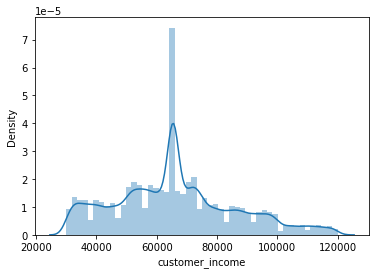

In [50]:
sns.distplot(merged_df['customer_income'], bins=50, hist_kws={'alpha': 0.4});

## 3.3 Most used offer by the customers

<AxesSubplot:title={'center':' Distribution of offer types'}>

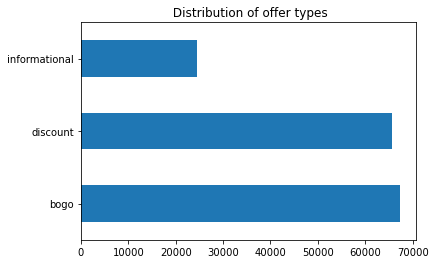

In [51]:
merged_df['offer_type'].value_counts().plot.barh(title=' Distribution of offer types')

BOGO and discount offers have nearly the same distributions

## 3.4 Age distribution of customers

<AxesSubplot:title={'center':' Distribution of age groups'}>

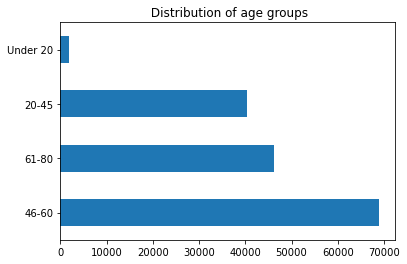

In [52]:
merged_df['Age_group'].value_counts().plot.barh(title=' Distribution of age groups')

It is quite surprising to see that customers with age 46-60 use Starbucks application the most, those with age 61-80 are on the second. One would usually think that customers between age 20-45 use app the most, but this is not the case here.

## 3.5 Actions to the offers that customers received

<AxesSubplot:title={'center':' Distribution of offers'}>

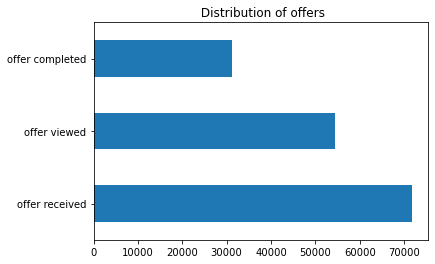

In [53]:
merged_df['event'].value_counts().plot.barh(title=' Distribution of offers')

This implies most of the customers don't pay attention to the offer, don't even have a look at it. Also, there are more number of customers who just view & ignore the offer than the one's who actually complete the offer.


For a better analysis, let us analyze the data based on gender.

## 3.6 Distribution of males & females

In [54]:
plot_gender = merged_df[merged_df['gender'] != 'O']

<AxesSubplot:ylabel='gender'>

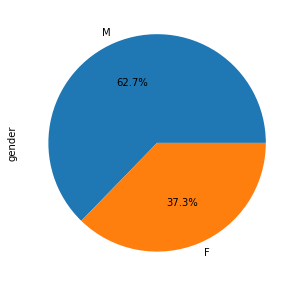

In [55]:
plot_gender.gender.value_counts().plot(kind='pie' , figsize=(5, 5), autopct='%1.1f%%')

## 3.7 Age group of males & females

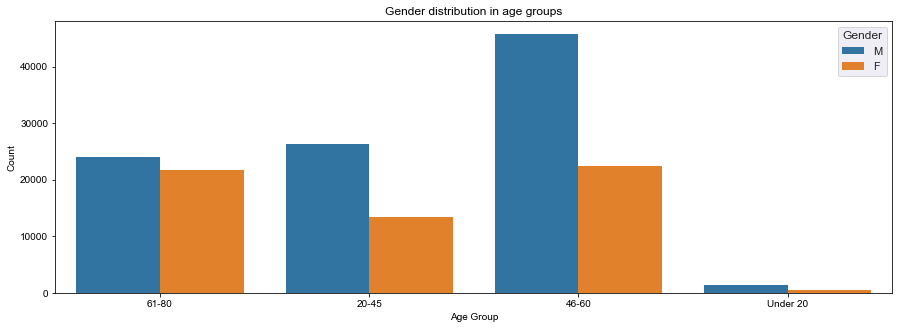

In [56]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

The male customers are more than the female ones in each age group.

## 3.8 Gender distribution in each offer type

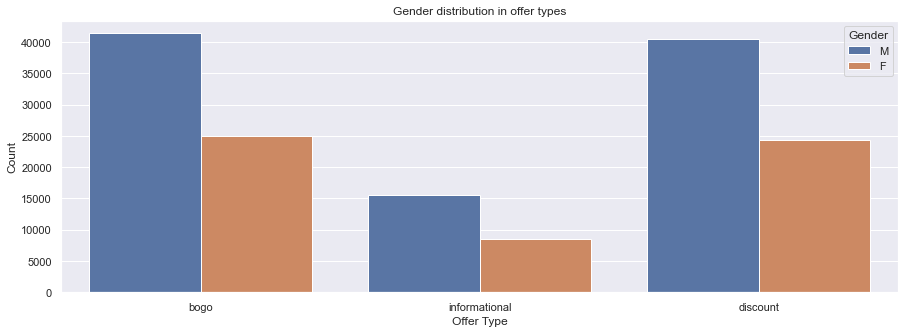

In [57]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

## 3.9 Actions to the offers that males & females received

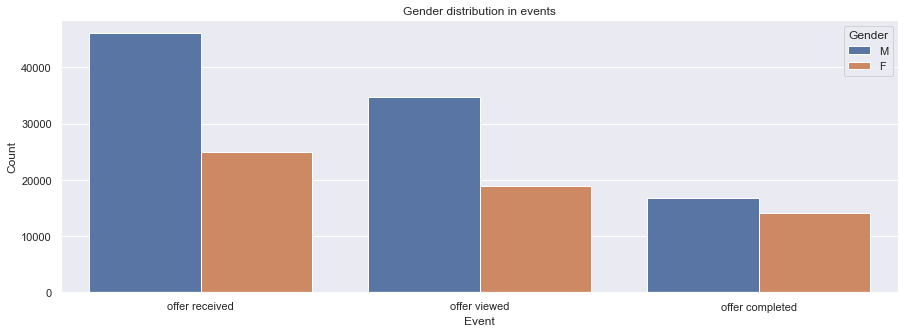

In [58]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Gender')

## 3.10 Actions to the offers in each offer type

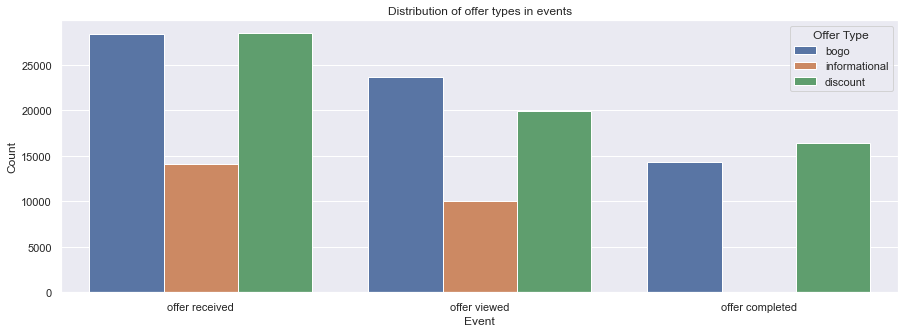

In [59]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Distribution of offer types in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')

In general, most people take the discount offer.

## 3.11 Actions to the offers in each age group

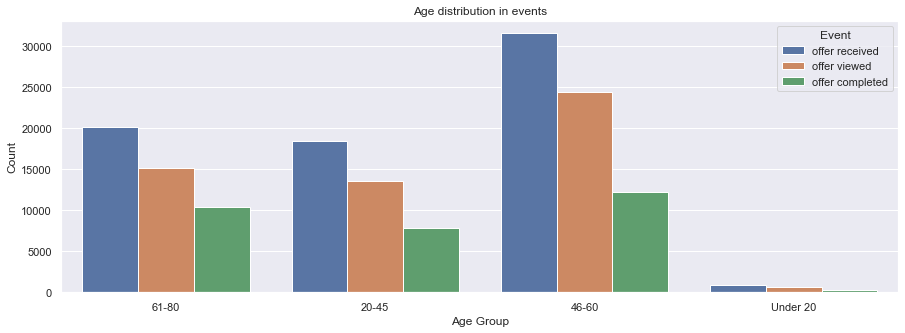

In [60]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "event", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Age distribution in events')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Event')

# 4. Build an ML model to predict the response of a customer to an offer

Before building a model, we'll have to clean & prepare the data to fit into the model.

## 4.1 Data Preparation and Cleaning II

In [61]:
merged_df.head()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id,customer_id,event,time,money_gained,money_spent,gender,became_member_on,customer_income,Age_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,20170909,100000.0,61-80
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,20170909,100000.0,61-80
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,20170909,100000.0,61-80
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,20170909,100000.0,61-80
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,20170909,100000.0,61-80


In [62]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157503 entries, 0 to 157502
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   offer_reward      157503 non-null  int64  
 1   channels          157503 non-null  object 
 2   offer_difficulty  157503 non-null  int64  
 3   offer_duration    157503 non-null  int64  
 4   offer_type        157503 non-null  object 
 5   offer_id          157503 non-null  object 
 6   customer_id       157503 non-null  object 
 7   event             157503 non-null  object 
 8   time              157503 non-null  int64  
 9   money_gained      157503 non-null  float64
 10  money_spent       157503 non-null  float64
 11  gender            157503 non-null  object 
 12  became_member_on  157503 non-null  int64  
 13  customer_income   157503 non-null  float64
 14  Age_group         157503 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 19.2+ MB


### Tasks
1. Encode categorical data such as gender, offer type, channel and age groups.
2. Encode the 'event' data to numerical values:

    • offer received ---> 1
    
    • offer viewed ---> 2
    
    • offer completed ---> 3
    
    
3. Encode offer id and customer id.
4. Drop column 'became_member_on' and add separate columns for month and year.
5. Scale and normalize numerical data.

In [63]:
def cleaning_final_data(df):
    """
    Clean merged data frame for the final data as per tasks 1-5.
    
    Parameters
    ----------
    df: input data frame
    
    Returns
    -------
    df: cleaned data frame as per tasks
       
    """
    #process categorical variables
    categorical = ['offer_type', 'gender', 'Age_group']
    df = pd.get_dummies(df, columns = categorical)
    
    #process channels column 
    df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())
    
    #process became_member_on column
    #change datatype of became_member_on 
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    
    #add new columns for month & year
    df['month_member'] = df['became_member_on'].apply(lambda x: x.day)
    df['year_member'] = df['became_member_on'].apply(lambda x: x.year)
    
    #drop became_member_on column
    df.drop('became_member_on',axis=1, inplace=True)    
    
    #process offer_id column
    offerids = df['offer_id'].unique().tolist()
    o_mapping = dict( zip(offerids,range(len(offerids))) )
    df.replace({'offer_id': o_mapping},inplace=True)
    
    #process customer_id column
    cusids = df['customer_id'].unique().tolist()
    c_mapping = dict( zip(cusids,range(len(cusids))) )
    df.replace({'customer_id': c_mapping},inplace=True)
    
    #process numerical variables
    #initialize a MinMaxScaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'money_gained', 'money_spent']
    df[numerical] = scaler.fit_transform(df[numerical])
    
    #encode 'event' data to numerical values according to task 2
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    return df

In [64]:
cleaned_data = cleaning_final_data(merged_df)

In [65]:
cleaned_data.head(10)

,offer_reward,offer_difficulty,offer_duration,offer_id,customer_id,event,time,money_gained,money_spent,customer_income,...,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web,month_member,year_member
0,1.0,0.5,0.571429,0,0,1,0.000000,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
1,1.0,0.5,0.571429,0,0,2,0.142857,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
2,1.0,0.5,0.571429,0,0,1,0.705882,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
3,1.0,0.5,0.571429,0,0,2,0.714286,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
4,1.0,0.5,0.571429,0,0,3,0.714286,1.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
5,0.0,0.0,0.142857,1,0,1,0.571429,0.0,0.0,0.777778,...,0,0,1,0,1,1,0,1,9,2017
6,0.0,0.0,0.142857,1,0,2,0.655462,0.0,0.0,0.777778,...,0,0,1,0,1,1,0,1,9,2017
7,0.5,1.0,1.000000,2,0,1,0.235294,0.0,0.0,0.777778,...,0,0,1,0,1,0,0,1,9,2017
8,0.5,1.0,1.000000,2,0,2,0.243697,0.0,0.0,0.777778,...,0,0,1,0,1,0,0,1,9,2017
9,0.5,1.0,1.000000,2,0,3,0.252101,0.5,0.0,0.777778,...,0,0,1,0,1,0,0,1,9,2017


In [66]:
cleaned_data.columns

Index(['offer_reward', 'offer_difficulty', 'offer_duration', 'offer_id',
       'customer_id', 'event', 'time', 'money_gained', 'money_spent',
       'customer_income', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'gender_F', 'gender_M', 'gender_O',
       'Age_group_20-45', 'Age_group_46-60', 'Age_group_61-80',
       'Age_group_Under 20', 'email', 'mobile', 'social', 'web',
       'month_member', 'year_member'],
      dtype='object')

In [67]:
cleaned_data.shape

(157503, 26)

In [68]:
cleaned_data.event.value_counts()

1    71863
2    54396
3    31244
Name: event, dtype: int64

## 4.2 Splitting the train and test data

Final data is ready after tasks 1-5. We will now split the data (both features and their labels) into training and test sets, taking 60% of data for training and 40% for testing.

In [69]:
data = cleaned_data.drop('event', axis=1)
label = cleaned_data['event']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.4, random_state = 0)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 94501 rows
Testing set: 63002 rows


## 4.3 Training and Testing Data

## Metrics

We will consider the F1 score as the model metric to assess the quality of the approach and determine which model gives the best results. It can be interpreted as the weighted average of the precision and recall. The traditional or balanced F-score (F1 score) is the harmonic mean of precision and recall, where an F1 score reaches its best value at 100 and worst at 0.

In [71]:
def train_test(clf):
    """
    Return train and test F1 score along with the model name
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

In [72]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Takes a fitted the model and evaluates its prediction on the
    training and test data using accuracy score and classification report
    
    Input
    -----
    model: the fittes model to be evaluated
    X_train: the training predictor dataset
    y_train: the training response dataset
    X_test: the test predictor dataset
    y_test: the test response dataset
    
    Output
    -------
    
    """
    
    train_pred=model.predict(X_train)
    test_pred=model.predict(X_test)
    
    train_report=classification_report(y_train, train_pred)
    test_report=classification_report(y_test, test_pred)
    
    return train_report, test_report

## 4.4 Model Evaluation based on F1-score

All the Ml model as well as the refined model are evaluated based on F1 score metrics. The models are evaluated on training and testing F1 score and later compared with the same metrics.

## 4.4.1 KNeighborsClassifier (Benchmark) Model

We use the K-Nearest Neighbors algorithm to build the benchmark, and evaluate the model result by the F1 score metric. The reason we use KNN algorithm is because it provides better classification on the data by calculating the distance between the datapoints and this problem can be solved using classification algorithms. 

In [73]:
clf_A = KNeighborsClassifier(n_neighbors = 5)
a_train_f1, a_test_f1, a_model = train_test(clf_A)

In [74]:
knn = {'KNN Benchmark Model': [ a_model], 'train F1 score':[a_train_f1], 'test F1 score': [a_test_f1]}
benchmark = pd.DataFrame(knn)

In [75]:
benchmark

,KNN Benchmark Model,train F1 score,test F1 score
0,KNeighborsClassifier,54.35498,32.859274


## 4.4.2 RandomForestClassifier Model

Here, we used Random Forest Classifier as it will evaluate the model on multiple decision trees and choose the best one to provide the results. It randomly selects observations/rows and specific features/variables to build multiple decision trees from and then averages the results. I haven't given parameters except for the 'random_state' because my computer was consuming more computational resources as well as time.

In [76]:
clf_B = RandomForestClassifier(random_state = 10)
b_train_f1, b_test_f1, b_model = train_test(clf_B)

In [77]:
rfc = {'RandomForestClassifier Model': [ b_model], 'train F1 score':[b_train_f1], 'test F1 score': [b_test_f1]}
model_r = pd.DataFrame(rfc)

In [78]:
model_r

,RandomForestClassifier Model,train F1 score,test F1 score
0,RandomForestClassifier,95.455075,72.783404


## 4.4.3 DecisionTreeClassifier Model

Decision Tree Classifier is used as a third model as it can give better decisions on boolean type values such as yes or No, Received or Rejected and so on. DT is built on an entire dataset, using all the features/variables of interest and provide well decisions. 

In [79]:
clf_C = DecisionTreeClassifier(random_state = 10)
c_train_f1, c_test_f1, c_model = train_test(clf_C)

In [80]:
dtc = {'RandomForestClassifier Model': [ c_model], 'train F1 score':[c_train_f1], 'test F1 score': [c_test_f1]}
model_d = pd.DataFrame(dtc)

In [81]:
model_d

,RandomForestClassifier Model,train F1 score,test F1 score
0,DecisionTreeClassifier,95.455075,85.079839


## 4.5 Model Refinement and Validation

As we can see the models RandomForestClassifier, and DecisionTreeClassifier gave a sufficiently better result compared to the benchmark model therefore I performed hyperparameter tuning on the benchmark model – KNeighborsClassifier to refine the model. We use the K-Nearest Neighbors benchmark model to improve and refine the model, and evaluate the model result by the F1 score metric. Here, I've used RandomizedSearchCV validation method to refine the model using hyperparameter tuning method. 

## 4.5.1 Hyperparameter Tuning

In [82]:
params = {
    'n_neighbors':[7, 9],
    'metric':['minkowski','manhattan']
}

cv = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions=params, cv=2, n_iter = 1, verbose=1, 
                        n_jobs=-1, random_state=42)

In [83]:
# fit the cv model
cv.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2, estimator=KNeighborsClassifier(), n_iter=1, n_jobs=-1,
                   param_distributions={'metric': ['minkowski', 'manhattan'],
                                        'n_neighbors': [7, 9]},
                   random_state=42, verbose=1)

In [84]:
cv.best_params_

{'n_neighbors': 9, 'metric': 'minkowski'}

To validate the model and tune the hyperparameters, I used the RandomizedSearchCV validation method. The reason behind this was the GridSearchCV was consuming more computational power and time and wasn’t providing the results. I refined the benchmark model on the parameter – ‘n_neighbors’ list and ‘metric’ list. I also used fewer parameters to avoid the greater usage of CPU/GPU of my laptop as it was not providing results. Also, I lessened the number of iterations and the folds in the RandomizedSearchCV validation process for the same reason mentioned previously. 

## 4.5.2 Refined Model evaluation and validation

In [85]:
clf_D = KNeighborsClassifier(n_neighbors = 9, metric = 'minkowski')
d_train_f1, d_test_f1, d_model = train_test(clf_D)

In [86]:
new_knn = {'Refined KNN Benchmark Model': [ d_model], 'train F1 score':[d_train_f1], 'test F1 score': [d_test_f1]}
new_benchmark = pd.DataFrame(new_knn)

In [87]:
new_benchmark

,Refined KNN Benchmark Model,train F1 score,test F1 score
0,KNeighborsClassifier,51.82379,35.902035


There wasn’t much difference obtained, the training F1 score was fair and similar to the previous model but the testing F1 score improved from 33% to 36%. 

## 4.6 Model Evaluation Report

The ML models as well as the refined model were evaluated on the F1 score metrics. The training and testing F1 scores of these models are already mentioned in the Model Refinement and Validation section. Let us see a detailed classification report and the accuracy distribution of all these models. 

In [88]:
def print_report(models, X_train, y_train, X_test, y_test):
    """
    prints the classification report for all the models passed in
    
    Input
    -----
    models: list of fitted models
    """
    for model in models:
        train_report, test_report=evaluate_model(model, X_train, y_train, X_test, y_test)
        print(model.__class__.__name__)
        print('-'*20)
        print('Train Report')
        print(train_report)
        print('Test Report')
        print(test_report)
        print('-'*20)
        print()

In [89]:
print_report([cv], X_train, y_train, X_test, y_test)

RandomizedSearchCV
--------------------
Train Report
              precision    recall  f1-score   support

           1       0.51      0.83      0.63     43232
           2       0.51      0.31      0.39     32553
           3       0.62      0.17      0.26     18716

    accuracy                           0.52     94501
   macro avg       0.55      0.43      0.43     94501
weighted avg       0.53      0.52      0.47     94501

Test Report
              precision    recall  f1-score   support

           1       0.41      0.66      0.51     28631
           2       0.22      0.14      0.17     21843
           3       0.22      0.05      0.09     12528

    accuracy                           0.36     63002
   macro avg       0.28      0.28      0.25     63002
weighted avg       0.31      0.36      0.31     63002

--------------------



Above report gives details of the refined model's classification report and it's accuracy score

In [90]:
models=[clf_A, clf_B, clf_C, clf_D]
print_report(models, X_train, y_train, X_test, y_test)

KNeighborsClassifier
--------------------
Train Report
              precision    recall  f1-score   support

           1       0.54      0.84      0.66     43232
           2       0.52      0.38      0.44     32553
           3       0.82      0.15      0.25     18716

    accuracy                           0.54     94501
   macro avg       0.62      0.46      0.45     94501
weighted avg       0.59      0.54      0.50     94501

Test Report
              precision    recall  f1-score   support

           1       0.39      0.60      0.47     28631
           2       0.19      0.15      0.17     21843
           3       0.19      0.03      0.05     12528

    accuracy                           0.33     63002
   macro avg       0.26      0.26      0.23     63002
weighted avg       0.28      0.33      0.28     63002

--------------------

RandomForestClassifier
--------------------
Train Report
              precision    recall  f1-score   support

           1       0.93      0.97    

# 5. Conclusion

## 5.1 EDA

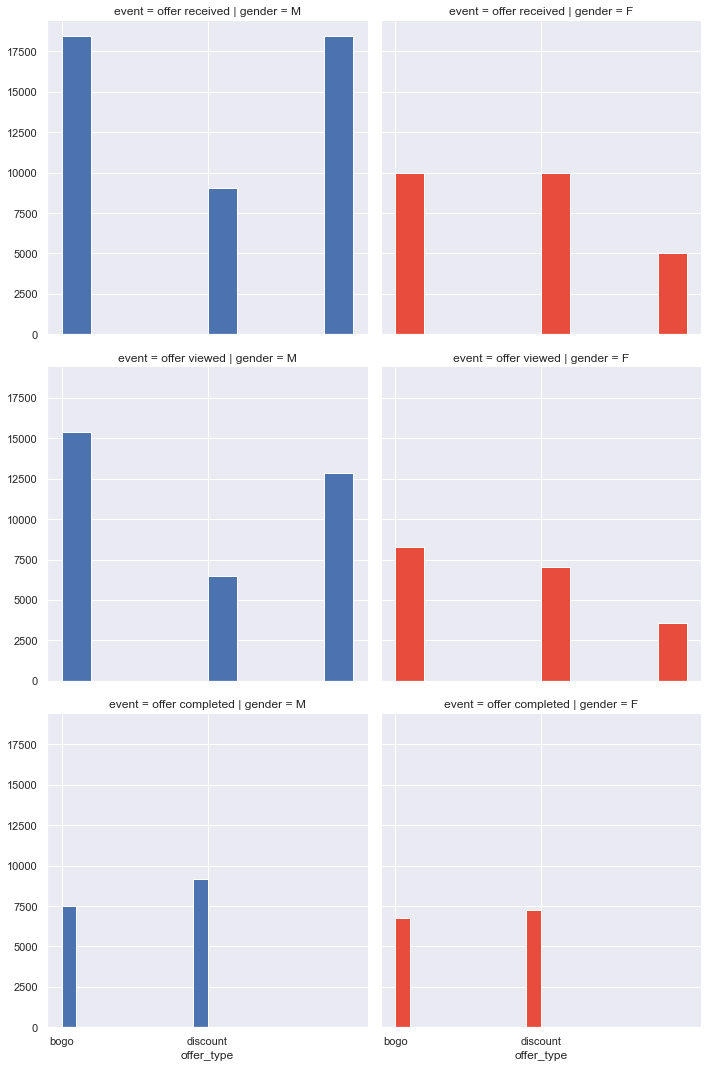

In [91]:
d = {'color': ['C0', "#e74c3c"]}
g = sns.FacetGrid(plot_gender, row='event', col='gender', hue_kws=d, hue='gender', size=5)
g.map(plt.hist, 'offer_type')

The males represent 62.7% of the data and use the Starbucks app more than the females. Specifically, both males & females in the age group 46-60 use app the most. Discount offers are more preferred by the customers. Also, there are less number of customers who actually complete the offer as compared to the ones who just view & ignore it. We can look more to the figures & information in section- 3) Exploratory Data Analysis (points 3.2-3.11) to best determine which kind of offers to send to the customers.

## 5.2 Model comparison and evaluation against the model metric

In [92]:
models = {'Model': ['KNeighborsClassifier (Benchmark)', 'Refined KNeighborsClassifier', b_model, c_model], 
          'train F1 score ':[a_train_f1, d_train_f1, b_train_f1, c_train_f1], 
          'test F1 score': [a_test_f1 , d_test_f1, b_test_f1, c_test_f1] }
          
comp = pd.DataFrame(models)

In [93]:
comp

,Model,train F1 score,test F1 score
0,KNeighborsClassifier (Benchmark),54.354980,32.859274
1,Refined KNeighborsClassifier,51.823790,35.902035
2,RandomForestClassifier,95.455075,72.783404
3,DecisionTreeClassifier,95.455075,85.079839


## 5.3 Justification

The validation set (test data set) is used to evaluate the model. Both models are better than the benchmark. The best score is created by the DecisionTreeClassifier model, as its validation F1 score is 85.07, which is much higher than the benchmark. The RandomForestClassifier model scores well as well compared to the benchmark, with a test F1 score of 72.78. The Refined KNeighborsClassifier after hyperparameter tuning didn't give much improvement but its validation was 3% higher than the benchmark model. 

Our problem to solve is not that sensitive which requires a very high F1 score, so the scores are good & sufficient and can be used for the classification purpose to predict whether a customer will respond to an offer. 